#  Basic demonstration of pyMCR

In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from pymcr.mcr import McrAls

# Define model system

## Spectra

In [2]:
# wn = np.linspace(400,2800,200)

# n_components = 3

# sp0 = np.exp(-(wn-1200)**2/(2*200**2))
# sp1 = np.exp(-(wn-1600)**2/(2*200**2))
# sp2 = np.exp(-(wn-2000)**2/(2*200**2))

# plt.plot(wn, sp0, label='Spectrum 0')
# plt.plot(wn, sp1, label='Spectrum 1')
# plt.plot(wn, sp2, label='Spectrum 2')
# plt.xlabel(r'Wavenumber (cm$^{-1}$)')
# plt.ylabel('Intensity (au)')
# plt.legend(loc='best')
# plt.title('Spectral Components')

## Concentration map

In [3]:
# # Model starts off as 3 2D-Gaussian centered at (x*, y*)
# # with standard deviation R (1 for each component).
# # The sum to 1 constraint is then enforced.

# x0 = 25
# y0 = 25

# x1 = 75
# y1 = 25

# x2 = 50
# y2 = 50

# R = 20

# M=50  # rows (Y)
# N= 100  # cols (X)

# # Init concentration map
# conc = np.zeros((M,N,n_components))

# X,Y = np.meshgrid(np.arange(N), np.arange(M))

# conc[...,0] = np.exp(-(X-x0)**2/(2*R**2))*np.exp(-(Y-y0)**2/(2*R**2))
# conc[...,1] = np.exp(-(X-x1)**2/(2*R**2))*np.exp(-(Y-y1)**2/(2*R**2))
# conc[...,2] = np.exp(-(X-x2)**2/(2*R**2))*np.exp(-(Y-y2)**2/(2*R**2))

# conc /= conc.sum(axis=-1)[:,:,None]

# # Find the maximum concentration (per component)
# # and set to conc = 1 (and make the rest 0's)
# # This just ensures that each component has a pure
# # pixel somewhere within the image
# for num in range(n_components):
#     idx = np.unravel_index(conc[...,num].argmax(), conc[...,num].shape)
#     tmp = np.zeros(3)
#     tmp[num] = 1
#     conc[idx[0],idx[1],:] = 1*tmp

# plt.figure(figsize=(6,4))
# for num in range(3):
#     plt.subplot(2,2,num+1)
#     plt.imshow(conc[...,num])
#     plt.colorbar()
#     plt.axis('off')
#     plt.title('Component {}'.format(num))

# plt.subplot(2,2,4)
# plt.imshow(conc.sum(axis=-1))
# plt.colorbar()
# plt.axis('off')
# plt.title('Sum of Conc\'s')
# plt.tight_layout()

In [4]:
# # Stack 3 spectral vectors into 1 matrix
# spectra = np.vstack((sp0, sp1, sp2))

# # Hyperspectral image (HSI)
# hsi = np.dot(conc, spectra)

In [5]:
n_colors = 200
wn = np.linspace(400,2800,n_colors)

n_components = 3
sp0 = np.exp(-(wn-1200)**2/(2*200**2))
sp1 = np.exp(-(wn-1600)**2/(2*200**2))
sp2 = np.exp(-(wn-2000)**2/(2*200**2))
spectra = np.vstack((sp0, sp1, sp2))

M = 80
N = 120
n_spectra = M * N

conc = np.zeros((M,N,n_components))

x0 = 25
y0 = 25

x1 = 75
y1 = 25

x2 = 50
y2 = 50

R = 20

X,Y = np.meshgrid(np.arange(N), np.arange(M))

conc[...,0] = np.exp(-(X-x0)**2/(2*R**2))*np.exp(-(Y-y0)**2/(2*R**2))
conc[...,1] = np.exp(-(X-x1)**2/(2*R**2))*np.exp(-(Y-y1)**2/(2*R**2))
conc[...,2] = np.exp(-(X-x2)**2/(2*R**2))*np.exp(-(Y-y2)**2/(2*R**2))

conc /= conc.sum(axis=-1)[:,:,None]

for num in range(n_components):
    idx = np.unravel_index(conc[...,num].argmax(), conc[...,num].shape)
    tmp = np.zeros(3)
    tmp[num] = 1
    conc[idx[0],idx[1],:] = 1*tmp

hsi = np.dot(conc, spectra)

# Perform MCR-ALS

## With spectral guess

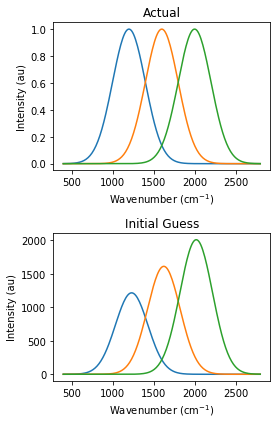

In [6]:
# Poor guess
initial_spectra = spectra*wn

plt.figure(figsize=(4,6))
plt.subplot(211)
plt.plot(wn, spectra.T)
plt.xlabel(r'Wavenumber (cm$^{-1}$)')
plt.ylabel('Intensity (au)')
plt.title('Actual')

plt.subplot(212)
plt.plot(wn, initial_spectra.T)
plt.xlabel(r'Wavenumber (cm$^{-1}$)')
plt.ylabel('Intensity (au)')
plt.title('Initial Guess')

plt.tight_layout()

In [14]:
mcrals = McrAls(max_iter=200, tol_mse=1e-7, tol_dif_conc=1e-6, tol_dif_spect=1e-8)
mcrals.fit(hsi.reshape((-1, wn.size)), initial_spectra=initial_spectra)
print('\nFinal MSE: {:.7e}'.format(mcrals.mse[-1]))
print('Final C_MRD: {:.7e}'.format(mcrals._c_mrd))
print('Final ST_MRD: {:.7e}'.format(mcrals._st_mrd))

iteration 1 : MSE 3.85e-04
iteration 2 : MSE 6.82e-05
iteration 3 : MSE 3.48e-05
iteration 4 : MSE 2.14e-05
iteration 5 : MSE 1.43e-05
iteration 6 : MSE 1.01e-05
iteration 7 : MSE 7.38e-06
iteration 8 : MSE 5.59e-06
iteration 9 : MSE 4.35e-06
iteration 10 : MSE 3.46e-06
iteration 11 : MSE 2.80e-06
iteration 12 : MSE 2.31e-06
iteration 13 : MSE 1.93e-06
iteration 14 : MSE 1.64e-06
iteration 15 : MSE 1.40e-06
iteration 16 : MSE 1.21e-06
iteration 17 : MSE 1.06e-06
iteration 18 : MSE 9.32e-07
iteration 19 : MSE 8.26e-07
iteration 20 : MSE 7.37e-07
iteration 21 : MSE 6.62e-07
iteration 22 : MSE 5.98e-07
iteration 23 : MSE 5.43e-07
iteration 24 : MSE 4.95e-07
iteration 25 : MSE 4.53e-07
iteration 26 : MSE 4.16e-07
iteration 27 : MSE 3.83e-07
iteration 28 : MSE 3.54e-07
iteration 29 : MSE 3.29e-07
iteration 30 : MSE 3.06e-07
iteration 31 : MSE 2.85e-07
iteration 32 : MSE 2.67e-07
iteration 33 : MSE 2.50e-07
iteration 34 : MSE 2.35e-07
iteration 35 : MSE 2.21e-07
iteration 36 : MSE 2.09e-07
i

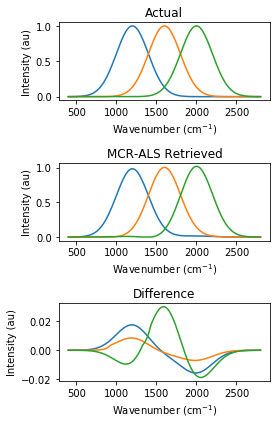

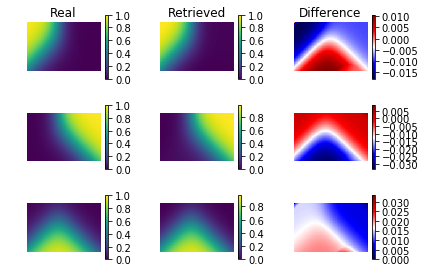

In [15]:
plt.figure(figsize=(4,6))
plt.subplot(311)
plt.plot(wn, spectra.T)
plt.xlabel(r'Wavenumber (cm$^{-1}$)')
plt.ylabel('Intensity (au)')
plt.title('Actual')

plt.subplot(312)
plt.plot(wn, mcrals.spectra_.T)
plt.xlabel(r'Wavenumber (cm$^{-1}$)')
plt.ylabel('Intensity (au)')
plt.title('MCR-ALS Retrieved')

plt.subplot(313)
plt.plot(wn, spectra.T - mcrals.spectra_.T)
plt.xlabel(r'Wavenumber (cm$^{-1}$)')
plt.ylabel('Intensity (au)')
plt.title('Difference')

plt.tight_layout()
plt.show()

temp = mcrals.conc_.reshape(conc.shape)
plt.figure(figsize=(6,4))
for num in range(n_components):
    plt.subplot(3,3,3*num+1)
    plt.imshow(conc[...,num])
    plt.colorbar()
    plt.axis('off')
    if num == 0:
        plt.title('Real')

    plt.subplot(3,3,3*num+2)
    plt.imshow(temp[...,num])
    plt.colorbar()
    plt.axis('off')

    if num == 0:
        plt.title('Retrieved')

    plt.subplot(3,3,3*num+3)
    plt.imshow(conc[...,num] - temp[...,num], cmap='seismic')
    plt.colorbar()
    plt.axis('off')

    if num == 0:
        plt.title('Difference')

plt.tight_layout()
plt.show()

## With concentration guess

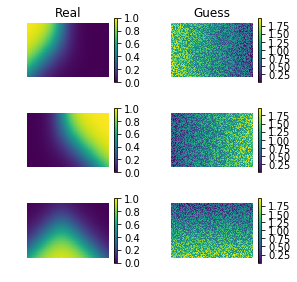

In [16]:
# Poor guess
initial_conc = np.zeros((M,N,3))
initial_conc[...,0] = np.dot(np.ones(M)[:,None], (np.arange(N,0,-1)/N)[None,:])
initial_conc[...,1] = np.dot(np.ones(M)[:,None], (np.arange(N)/N)[None,:])
initial_conc[...,2] = np.dot((np.arange(M)/M)[:,None], np.ones(N)[None,:])
initial_conc += np.random.rand(M,N,3)

plt.figure(figsize=(6,4))
for num in range(n_components):
    plt.subplot(3,3,3*num+1)
    plt.imshow(conc[...,num])
    plt.colorbar()
    plt.axis('off')
    if num == 0:
        plt.title('Real')

    plt.subplot(3,3,3*num+2)
    plt.imshow(initial_conc[...,num])
    plt.colorbar()
    plt.axis('off')
    if num == 0:
        plt.title('Guess')
plt.tight_layout()
    
# plt.figure(figsize=(4,6))
# plt.subplot(211)
# plt.plot(wn, spectra.T)
# plt.xlabel(r'Wavenumber (cm$^{-1}$)')
# plt.ylabel('Intensity (au)')
# plt.title('Actual')

# plt.subplot(212)
# plt.plot(wn, initial_spectra.T)
# plt.xlabel(r'Wavenumber (cm$^{-1}$)')
# plt.ylabel('Intensity (au)')
# plt.title('Initial Guess')

# plt.tight_layout()

In [18]:
mcrals = McrAls(max_iter=200, tol_mse=1e-7, tol_dif_conc=1e-7, tol_dif_spect=1e-7)
mcrals.fit(hsi.reshape((-1, wn.size)), initial_conc=initial_conc.reshape((-1, 3)))
print('\nFinal MSE: {:.7e}'.format(mcrals.mse[-1]))
print('Final C_MRD: {:.7e}'.format(mcrals._c_mrd))
print('Final ST_MRD: {:.7e}'.format(mcrals._st_mrd))

iteration 1 : MSE 2.77e-02
iteration 2 : MSE 4.77e-03
iteration 3 : MSE 4.52e-04
iteration 4 : MSE 1.44e-04
iteration 5 : MSE 6.66e-05
iteration 6 : MSE 3.72e-05
iteration 7 : MSE 2.34e-05
iteration 8 : MSE 1.58e-05
iteration 9 : MSE 1.13e-05
iteration 10 : MSE 8.42e-06
iteration 11 : MSE 6.47e-06
iteration 12 : MSE 5.11e-06
iteration 13 : MSE 4.12e-06
iteration 14 : MSE 3.38e-06
iteration 15 : MSE 2.82e-06
iteration 16 : MSE 2.38e-06
iteration 17 : MSE 2.04e-06
iteration 18 : MSE 1.76e-06
iteration 19 : MSE 1.53e-06
iteration 20 : MSE 1.35e-06
iteration 21 : MSE 1.19e-06
iteration 22 : MSE 1.06e-06
iteration 23 : MSE 9.51e-07
iteration 24 : MSE 8.57e-07
iteration 25 : MSE 7.76e-07
iteration 26 : MSE 7.06e-07
iteration 27 : MSE 6.45e-07
iteration 28 : MSE 5.91e-07
iteration 29 : MSE 5.44e-07
iteration 30 : MSE 5.02e-07
iteration 31 : MSE 4.64e-07
iteration 32 : MSE 4.31e-07
iteration 33 : MSE 4.01e-07
iteration 34 : MSE 3.74e-07
iteration 35 : MSE 3.50e-07
iteration 36 : MSE 3.28e-07
i

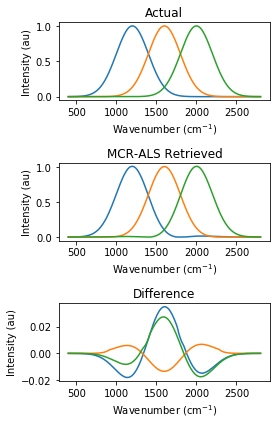

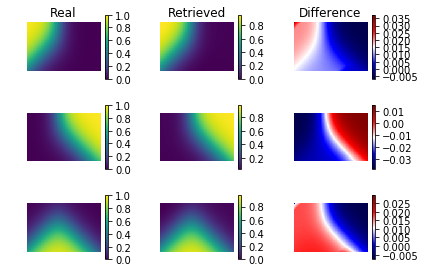

In [19]:
plt.figure(figsize=(4,6))
plt.subplot(311)
plt.plot(wn, spectra.T)
plt.xlabel(r'Wavenumber (cm$^{-1}$)')
plt.ylabel('Intensity (au)')
plt.title('Actual')

plt.subplot(312)
plt.plot(wn, mcrals.spectra_.T)
plt.xlabel(r'Wavenumber (cm$^{-1}$)')
plt.ylabel('Intensity (au)')
plt.title('MCR-ALS Retrieved')

plt.subplot(313)
plt.plot(wn, spectra.T - mcrals.spectra_.T)
plt.xlabel(r'Wavenumber (cm$^{-1}$)')
plt.ylabel('Intensity (au)')
plt.title('Difference')

plt.tight_layout()
plt.show()

temp = mcrals.conc_.reshape(conc.shape)
plt.figure(figsize=(6,4))
for num in range(n_components):
    plt.subplot(3,3,3*num+1)
    plt.imshow(conc[...,num])
    plt.colorbar()
    plt.axis('off')
    if num == 0:
        plt.title('Real')

    plt.subplot(3,3,3*num+2)
    plt.imshow(temp[...,num])
    plt.colorbar()
    plt.axis('off')

    if num == 0:
        plt.title('Retrieved')

    plt.subplot(3,3,3*num+3)
    plt.imshow(conc[...,num] - temp[...,num], cmap='seismic')
    plt.colorbar()
    plt.axis('off')

    if num == 0:
        plt.title('Difference')

plt.tight_layout()
plt.show()